In [1]:
%config Completer.use_jedi = False

In [2]:
reset -fs

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.neighbors       import KNeighborsClassifier



from sklearn.feature_selection import SelectFromModel

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator

from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm             import SVC

from sklearn.decomposition   import PCA

import imblearn
from   imblearn.pipeline          import make_pipeline # scikit-learn Pipeline does not work with imblearn

from sklearn.metrics import balanced_accuracy_score, fbeta_score, f1_score, confusion_matrix, make_scorer
from sklearn.metrics import plot_confusion_matrix, classification_report


from imblearn.pipeline import Pipeline

# Data Science Research Question
-----
## Can we develop an ML model to predict whether or not a patient will have a death event based on common heart failure predictors? Additionally, what are the most important predictors of a death event?

In [4]:
data = pd.read_csv('data/heart_failure_clinical_records_dataset.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


First after very basic EDA, I summarize the features in this dataset, and how they relate to heart failure:
- **Age** - age of patient in years
- **Anaemia** - whether or not a patient has a decrease of red blood cells (boolean)
- **Creatinine Phosphokinase** - level of CPK enzyme in blood in (high values may indicate muscle damage - heart is a muscle)
- **Diabetes** - whether or not a patient has diabetes (boolean)
- **Ejection Fraction** - percentage of blood being pumped out of left ventricle (lower values may indicate issues)
- **High Blood Pressure** - whether or not a patient has hypertension (boolean)
- **Platelets** - concentration of platelets in blood in kiloplatelets/mL
- **Serum Creatinine** - concentration of creatinine in blood in mg/dL (increased levels are a marker of poor cardiac output).
- **Serum Sodium** - level of sodium in blood in mEq/L (low concentration is a biological marker for heart failure)
- **Sex** - whether the patient is male or female (binary: 1=Male, 0=Female)
- **Smoking** - if the patient smokes (boolean)
- **Time** - the follow up period for the patient up to the death event (whether they died or were censored).
- **Death Event** - (target), whether or not the patient died during the follow up (boolean)
    - 1 - patient died
    - 0 - patient was censored (scientist lost contact with patient) 

Since the time variable is populated when the scientists either lost contact with the patient, or the patient died, it is indicative of survival, and obviously not known beforehand. In other words, if we were to deploy a working model with all the columns and someone wanted to predict whether a certain patient was likely to have a death event, they would have no "time" variable to put as an input (since that is recorded when the patient dies). Therefore, I made the decision initially to drop time as a predictor.

In [5]:
y = data.DEATH_EVENT # Our target variable is DEATH_EVENT 
X = data.drop(columns=['DEATH_EVENT', 'time'])  # Remove the target variable and time from X

In [6]:
# How many observations do we have?
len(X)

299

After importing the data, the next step is to pull off a segment of the data that will be our testing set. This test set will be be hidden away from the models we are designing until we are ready to test a final one. Additionally, since there are only have 299 observations, I am going to split the data by a slightly higher percentage (25% as opposed to 20%) to ensure that the testing set is representative of the data.

In [7]:
# Testing split that we are going to hide away from our model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 

# Feature Engineering
-----

After performing more extensive EDA (in a different notebook), I noticed that all of the columns were numeric types, but some represented categorical variables (i.e. whether or not someone smokes, has high blood pressure, etc.). In the dataset, these columns are already one-hot-encoded with binary 1's or 0's to indicate whether someone exhibits that characteristic. Therefore, in my feature engineering one-hot-encoding is not needed. Additionally, there are no Nan values in the training data, however I still impute for missing values, as they might be included in the testing set or data we want to use the model on.

For my feature engineering, the steps I took were:
1. Identify categorical and numerical columns and establish pipelines for each


2. Scale the data
    - For my numeric data I chose to use `StandardScaler()` in the pipeline, which normalizes columns to a normal distribution. This is important as many algorithms may perform poorly if individual features are not standardized. Additionally, standardization improves efficiency of many of these algorithms.
    - It doesn't make sense to use a scaler on my categorical columns since they're simply one-hot-encoded as 1s or 0s.


3. Impute missing values with `SimpleImputer()`
    - For numerical columns I used the strategy *median* whereas for categorical I used *most_frequent*. These methods fill any missing values with the corresponding strategy applied to the column.

In [8]:
X.info()  # Datatypes in all columns are either integer or float 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 25.8 KB


In [9]:
cat_cols = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']  # These are all binary
con_cols = ['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'age']

In [10]:
con_pipe = Pipeline([('scaler', StandardScaler()),  # Standard scaler for numerical variables
                     ('imputer', SimpleImputer(strategy='median', add_indicator=True))])


cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent'))])  # Shouldn't standardize binary variables



# Apply numerical and categorical pipeline to pre-processing step
preprocessing = ColumnTransformer([('categorical', cat_pipe, cat_cols), 
                                   ('continuous', con_pipe, con_cols)])

Additionally, when looking at the target variable Death_event, I saw evidence of slight imbalanced data as the percentage of death events in the target variable was around 32%. Therefore, I will make sure to use metrics that weigh the classes so as to deal with this imbalance.

In [11]:
np.unique(y, return_counts=True)

(array([0, 1]), array([203,  96]))

# Algorithms & Search
-----

To analyze which algorithm has the best performance I utilize automated algorithm and hyperparameter search. For the search, it is important that I gear my metric towards the particular business problem. 

In the case of predicting whether or not a patient is going to have a death event, I want to put an emphasis on recall, as we want to reduce the amount of false negatives (instances when our model doesn't predict death event and the patient dies). We are less concerned about recall (of patients *predicted* to die, how many did we get right?) When dealing with human lives it is better to be "safe than sorry", so we aren't concerned with our "success rate" when it comes to predicting death events. Its better if our model is conservative and tries to predict as many death events as it can (even if that means a few false positives). Therefore, I chose to use the `fbeta_score` metric, as it allows us to tweak the emphasis between precision and recall. Additionally, due to the slight imbalance between classes, I choose a *weighted* fbeta_score to help alleviate this issue.

When picking algorithms, I focused on three that are geared towards binary classification. I also provide details on the important parameters that will be tuned for each model via `RandomizedSearchCV()`. 

The three algorithms I chose to compare were:

1. `LogisticRegression()` - I chose this model because it is a linear model for *classification*, which is the scope of my research question in this case.
    - Important parameters:
     - `penalty` - Specifies the normalization used in the penalty term
     
     - `C` - Inverse of regularization strength was varied (smaller values result in stronger regularization)
     
     - `solver` - Algorithm that is used in the optimization problem 
     
     - `class_weight` - The weights associated with specific classes (if we have evidence of imbalanced data, setting to `balanced` may be helpful
     
     
     
2. `RandomForestClassifier()` - I chose this model because fitting a number of decision tree classifiers on various sub-samples of the data will improve accuracy in predictions and reduce overfitting 
    - Important parameters:
        - `n_estimators` - number of trees in the forest, important because adding more trees trained on different subsets of the data reduces variance
        - `criterion` - function used to determined the effectiveness of a split
        - `bootstrap` - whether or not to use bootstrap samples
            - **bootstrapping** is introducing amnesia by training trees on only a portion of the data, weakens the trees to improve *generality*
        - `min_samples_leaf` - the minimum amount of samples required to be in a leaf node, decreasing this can decrease the validation error
        - `class_weight` - weights assigned to classes (if None, classes are assumed to have a weight of 1)
            - **balanced** - uses values of y to adjust weights inversely to class frequencies
            - **balanced_subsample** - same as above, but weights are computed based on the bootstrap sample for every tree



3. `KNeighborsClassifier()` - I chose this model because it was one we learned about in 621, and I thought it would be interesting to see this models performance. We learned in 621 that KNeighbors is less often used in practice, but can still be effective nonetheless, and I was interested to see if it could outperform the other algorithms selected.
    - Important parameters:
        - `leaf_size` - Can affect speed and the optimal value will depend on the nature of the dataset (therefore I am going to test a decent range)
        - `n_neighbors` - Number of neighbors to use, can be unstable for the lowest values of n (i.e. 1) so start at 
        - `weights` - function to use for prediction
            - **uniform** - all points in neighborhood weighted equally
            - **distance** - weight points by inverse of distance (closer neighbors have greater influence)
        - `p` - power parameter for Minkowski (1=manhattan_distance, 2=euclidean_distance)

In [12]:
ftwo_scorer = make_scorer(fbeta_score, beta=2, average='weighted')  # Score to use in RandomizedSearchCV()

In [13]:
class DummyEstimator(BaseEstimator):
    "Pass through class, methods are present but do nothing."
    def fit(self): pass
    def score(self): pass

For the comments on importance of hyperparameters see markdown cell under Algorithms and Search

In [14]:
pipe = Pipeline(steps = [('preprocessing', preprocessing),
                         ('clf', DummyEstimator())])


search_space = [
        {'clf': [LogisticRegression(n_jobs=-1)],
            'clf__C': np.linspace(0.01, 5, 10),
            'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'clf__class_weight': ['balanced', None],
            'clf__penalty': ['l1', 'l2', 'elasticnet', 'none']},
                  
                  
        {'clf': [RandomForestClassifier(n_jobs=-1)],
            'clf__criterion': ['gini', 'entropy'],
            'clf__min_samples_leaf': np.linspace(1, 10, 6, dtype=int),
            'clf__bootstrap': [True, False],
            'clf__class_weight': [None, 'balanced', 'balanced_subsample'],
            'clf__n_estimators': np.linspace(0, 200, 100, dtype=int)},
    
        {'clf': [KNeighborsClassifier(n_jobs=-1)],
            'clf__leaf_size': np.linspace(0, 50, 10, dtype=int),
            'clf__n_neighbors': np.linspace(2, 13, 6, dtype=int),
            'clf__weights': ['uniform', 'distance'],
            'clf__p': [1,2]}]

    

gs = RandomizedSearchCV(pipe, 
                    search_space, 
                    scoring= ftwo_scorer,  # Used to combat slight class imbalance, and gear towards recall
                    n_iter=30,
                    cv=5,
                    n_jobs=-1
                    )

gs.fit(X_train, y_train)

best_model = gs.best_params_['clf']

gs.best_score_, gs.best_params_

(0.7896370084259293,
 {'clf__n_estimators': 80,
  'clf__min_samples_leaf': 8,
  'clf__criterion': 'entropy',
  'clf__class_weight': 'balanced_subsample',
  'clf__bootstrap': False,
  'clf': RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                         criterion='entropy', min_samples_leaf=8, n_estimators=80,
                         n_jobs=-1)})

As one can see the best model based on the cross validation and randomized search across algorithms and their hyperparameters is a RandomForestClassifier. To see the ideal parameters of the other models, one could comment out the other algorithms in the search_space.

# Evaluation Metrics
----

Now that I have my ideal model based on automated hyperparameter search and model selection, next I look at a variety of evaluation metrics on the testing data to assess our models performance on the testing set. The first metric I looked at was the weighted fbeta_score, since that is the metric I used to train my model.

In [15]:
pipe = Pipeline(steps = [('preprocessing', preprocessing), 
                         ('clf', best_model)])

fitted_model = pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [16]:
fbeta_score(y_test, y_pred, beta=2, average='weighted') 

0.6670355526310542

Another metric I chose to look at was balanced_accuracy_score, which gives the average of recall obtained in each class.

In [17]:
balanced_accuracy_score(y_test, y_pred)

0.6517991004497751

Next I look at the confusion matrix, to give us an idea of precision and recall for each class in our problem.

array([[33, 13],
       [12, 17]])

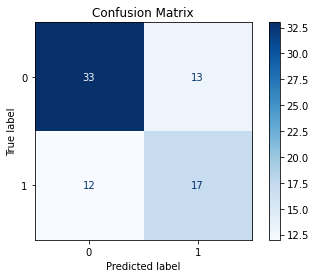

In [18]:
disp = plot_confusion_matrix(fitted_model, X_test, y_test, cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix')
disp.confusion_matrix

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.72      0.73        46
           1       0.57      0.59      0.58        29

    accuracy                           0.67        75
   macro avg       0.65      0.65      0.65        75
weighted avg       0.67      0.67      0.67        75



Above is a summary of the precision and recall in the chosen model. As one can see, our model still struggles with recall for predicting death events (class 1). It seems like the model performs well at predicting whether a patient lives (class 0), but struggles with death event. For further work I would like to further investigate how to improve our models performance when it comes to class 1.

# Feature Importance
----
To answer my question of which features are the best predictors of a death event I look at feature importance and select the 3 most influential features based on my ideal model.

In [20]:
fs = SelectFromModel(best_model, max_features=3)


fs.fit_transform(X_train, y_train)

features_to_keep = fs.get_support()

In [21]:
[x for x, y in zip(list(X.columns), list(features_to_keep)) if y == True]  # These are the most important features

['age', 'ejection_fraction', 'serum_creatinine']

As one can see from above, the most important features for predicting a death event are age, ejection_fraction, serum_creatine, and serum_sodium 

# Results and Conclusion
---

Below are the pipeline steps for my randomized search and model selection (DummyEstimator() is a placeholder for the three models analyzed in my randomized search):
- scaler for numerical columns
- imputation of missing values (median for continuous and mode for categorical)

In [24]:
gs.estimator  # RandomizedSearchCV pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['anaemia', 'diabetes',
                                                   'high_blood_pressure', 'sex',
                                                   'smoking']),
                                                 ('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strate

Based on my algorithm and hyperparameter search the single best model and its non-default hyperparameters are shown below:

In [22]:
best_model

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       criterion='entropy', min_samples_leaf=8, n_estimators=80,
                       n_jobs=-1)

Overall, I was somewhat successful at building a model to predict heart failure. My model is fairly accurate, however when I looked into the specific precision/recall for predicting a death event, I saw that my model struggled. Perhaps this has something to do with the class imbalance, but for future work I would like to research ways to improve this particular aspect of our performance. 

Given that Perhaps a simpler model (reducing the number of features) would have better predictive power 